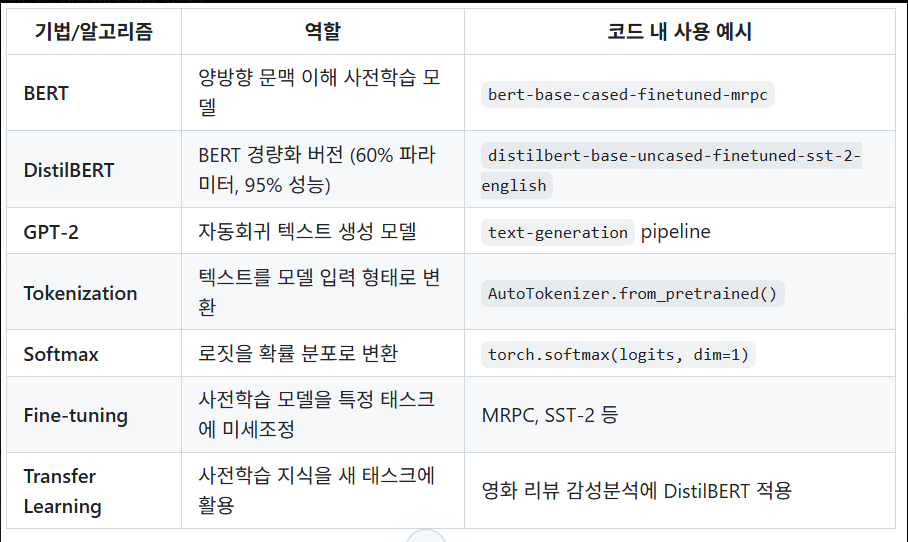
```
- 빈칸채우기

- 데이터
- Hugging Face Transformers Pipeline(간단한 api)
- 토크나이져 ( 텍스트 -> 토큰 -> 숫자 ID)
- 사전학습된 모델(BERT, GPT-2, DirstillBERT 등)
- 예측 결과(감성분석, 텍스트 생성, 문장 유사도)
- 후처리 평가(확률 변환, 정확도 계산)
```

```
"I went to the [MASK] to buy some milk"
BERT 예측 : [MASK] = "store" (앞뒤 문맥 buy, milk를 보고 추론)
```

### 사전학습 방법
    - MLM(Masked Language Model) : 문장의 15% 단어를 MASK 처리한 다음 예측
    - NSP(Next Sentence Prediction) : 두문장이 연결되는지 판단
```
사전학습(대규모 테스트)
[CLS] token 추가
특정 테스크 레이블로 학습(감성분석, QA 등)
```

### DistillBERT
    - BERT 압축버전 : 속도가 빠르다, 성능은 95% 유지함
    - 두꺼운 교과서(BERT)의 핵심만 추린 요약본(DistillBERT)
### 지식증류(Knowledge Distillation)
    - Teacher 모델(BERT) : 소프트레이블 생성(확률분포)
    - Student 모델(DistillBERT) : Teacher 출력을 모방
### GPT-2
    - 이전 단어들을 보고 다음 단어를 예측
    - 단방향 Attention
    - Zero-shot Learning : 특정 테스트 학습 없이도 수행 가능
    - GPT 시리즈
        - GPT-1 : 117M 파라미터
        - GPT-2 : 1.5B 파라미터
        - GPT-3 : 175B 파라미터(Few-shot Learning)
        - GPT-4 : 멀티모달

In [ ]:
import numpy as np
def softmax(logits):
    '''
    로짓을 확률 분포로 변환
    Args:
        logits : 모델의 출력 점수( [2.5, 1.0, 0.5] )
    Returns:
        확률 분포(합이 1인 배열)
    '''
    # 수치 안정성을 위해 최대값을 빼줌(오버플로우 방지)
    exp_logits = np.exp(logits - np.max(logits))
    return exp_logits / np.sum(exp_logits)
logits = np.array([2.5, 1.0, 0.5])
probs = softmax(logits)
print(f'logits : {logits}')
print(f'softmax : {probs}')
print(f'softmax sum : {np.sum(probs)}')

### WordPiece  Word + Piece
    - 단어를 자주 등장하는 조각(piece) 단위로 잘라서 처리
    - 기존 토크나이져 대비 --> 더 잘게 쪼개자. (Subword)
    - playing ---->  play + ##ing   ## 앞조각에 붙는 서브워드 라는 의미
    - 득템  ----------> 득 + 템

WordPiece 토큰화 시뮬레이션

In [ ]:
# %conda install transformers

In [ ]:
from transformers import AutoTokenizer
# BERT 토크나이져 로드
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# 테스트 문장
sentence = "I love natural language processing!"
# 토큰화
tokens = tokenizer.tokenize(sentence)
token_ids = tokenizer.encode(sentence)
# 디코딩
decoded = tokenizer.decode(token_ids)
print(f'원본문장 : {sentence}')
print(f'토큰목록 : {tokens}')
print(f'토큰ID : {token_ids}')
print(f'디코딩 결과 : {decoded}')

print(f'CLS토큰 : {tokenizer.cls_token} -> {tokenizer.cls_token_id}')
print(f'SEP토큰 : {tokenizer.sep_token} -> {tokenizer.sep_token_id}')
print(f'PAD토큰 : {tokenizer.pad_token} -> {tokenizer.pad_token_id}')

BERT로 문장 유사도 판단

In [ ]:
# AutoTokenizer  지정한 모델 이름에 맞게 토크나이져를 자동으로 불러오는 클래스
# AutoModelForSequenceClassification : 문장분류용 BERT 모델을 자동으로 로드
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# 모델 로드
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased-finetuned-mrpc')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased-finetuned-mrpc')
def check_similarity(sentence1, sentence2):
    '''
    두 문장의 의미적 유사도를 판단
    Returns:
        유사확률(0~1 사이 값)
    '''
    #1 토큰화
    inputs = tokenizer(sentence1, sentence2, return_tensors='pt')
    #2 모델추론
    with torch.no_grad():
        logits = model(**inputs).logits
    #3 softmax로 확률 변환
        probs = torch.softmax(logits, dim=1)[0]  # 0은 배치 배치를 제거
    #4 결과 반환
    return {
        'not_similar' : probs[0].item(),
        'similar' : probs[1].item()
    }
# 테스트 케이스
test_cases = [
    ("The cat is on the mat", "A feline is sitting on a rug"),
    ("I love pizza", "Python is a programming language"),
    ("He runs fast", "She walks slowly")
]
for sent1, sent2 in test_cases:
    result = check_similarity(sent1, sent2)
    print(f'문장1 : {sent1}')
    print(f'문장2 : {sent2}')
    print(f'유사확률 : {result["similar"]:.2f}\n')


GPT-2
```
다음 단어 후보와 확률
The cat is on the 다음에 단어 후보 와 확률
mat         0.4
root        0.25
bed         0.15
chair       0.10
floor       0.10

top-k  3  mat roof bed
top-p  0.8 

mat  0.40 -> 누적 0.40
roof 0.25 -> 누적 0.65
bed  0.15 -> 누적 0.80
```

GPT-2

In [ ]:
from transformers import GPT2LMHeadModel,GPT2Tokenizer
import torch
# 모델 로드
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained('gpt2')
def generate_text(prompt, max_length = 30):
    '''
    프롬프트 기반으로 텍스트 생성
    Args:
        prompt : 시작문장
        max_length : 최대 토큰수
    '''
    #1 입력 토큰화
    input_ids = tokenizer.encode(prompt,return_tensors='pt')
    #2 생성(다양한 전략)
    with torch.no_grad():  # 추론(평가)모드
        output = model.generate(
            input_ids,
            max_length = max_length,
            num_return_sequences = 1, # 생성할 문장 수
            temperature=0.8, # 창의성 조절
            top_k=50, # 샘플링전략  상위 k개의 단어만 선택
            top_p=0.95, # 누적확률 p 이상 단어만
            do_sample = True,  #확률적 셈플링
            pad_token_id = tokenizer.eos_token_id  # gpt2는 eos 토큰을 사용
        )

    #3 디코딩
    generated_txt = tokenizer.decode(output[0],skip_special_tokens=True)
    return generated_txt
prompts = [
    "Once upon a time",
    "In the year 2050,",
    "The secret to happiness is"
]
for prompt in prompts:
    result = generate_text(prompt)
    print(f'prompt : {prompt}')
    print(f'생성 : {result}\n')

- BertTokenizer : 직접호출
    - BEST 전용
    - bert-base-uncased,  bert-base-cased 등 BERT 계열만 지원
    - 다른 모델에서는 사용 불가
    - 모델 전환시 코드 수정
- AutoTokenizer : 자동선택
    - BERT RoBERTa, GPT-2, T5 다양한 모델 지원
    - from_pretrained에 모델 이름을 넣으면 
    - 어떤 클래스가 선택되었는지 모름 -> 세부구현시 세부옵션 확인

토큰목록 : ['[CLS]', 'the', 'cat', 'sat', 'on', 'the', 'mat', '[SEP]']
Attention 행렬 크기 : (8, 8)


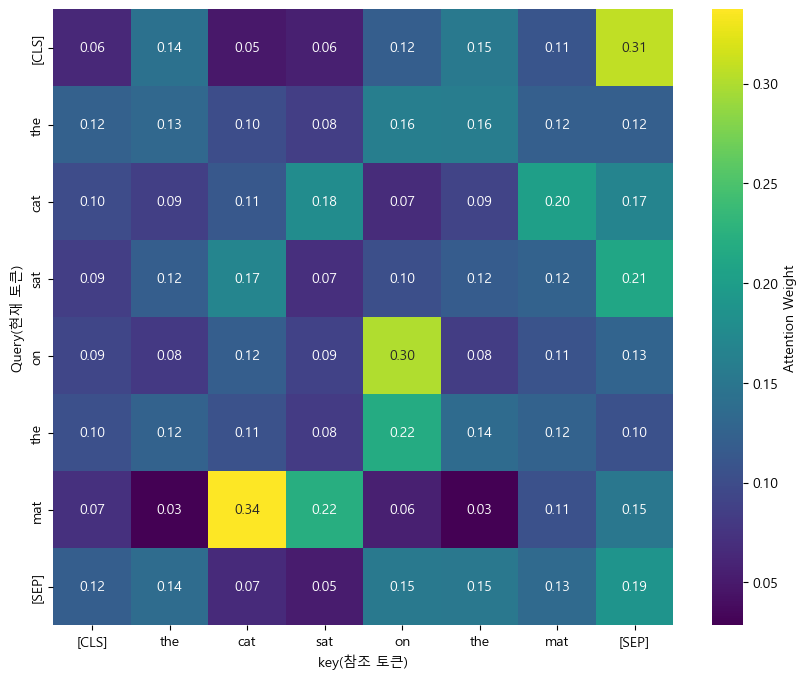

In [49]:
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 모델 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)

# self-Attention 가중치 시각화
sentence = 'The cat sat on the mat'
# 1 토큰화
inputs = tokenizer(sentence, return_tensors='pt')
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
# 2 모델생성(Attention 추출)
with torch.no_grad():
    outputs = model(**inputs)
    attentions = outputs.attentions  #12개 레이어의 Attention
# 3 첫번쨰 레이어, 첫 번재 헤드 Attention 시각화
attention = attentions[0][0,0].numpy()
plt.figure(figsize=(10,8))
sns.heatmap(
    attention,
    xticklabels=tokens,
    yticklabels=tokens,
    cmap='viridis',
    annot = True,
    fmt = '.2f',
    cbar_kws = {'label':'Attention Weight'},
)
plt.xlabel('key(참조 토큰)')
plt.ylabel('Query(현재 토큰)')

print(f'토큰목록 : {tokens}')
print(f'Attention 행렬 크기 : {attention.shape}')

In [ ]:
# Bert 모델을 이용해서 영화리뷰 감성분석
# 데이터셋 : NLTK movie_reviews
# 모델 DistillBERT
# 평가 : 분류 리포트
import nltk
from nltk.corpus import movie_reviews
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [ ]:
nltk.download('movie_reviews', quiet=True)

In [ ]:
reviews = [ movie_reviews.raw(id) for id in movie_reviews.fileids() ]
categories = [ movie_reviews.categories(id)[0] for id in movie_reviews.fileids() ]

In [ ]:
# pos 1  neg 0
y = np.array([1 if ca == 'pos' else 0 for ca in categories])
x_train, x_test, y_train, y_test = train_test_split(reviews, y, stratify=y, random_state=42, test_size=0.2)

In [ ]:
MODEL_NAME = 'distilbert-base-uncased-finetuned-sst-2-english'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [32]:
# 예측함수
def predict_sentiment(texts, batch_size=0):
    '''
    배치단위로 감성 예측
    Args:
        texts: 리뷰 텍스트 리스트
        batch_size: 한번에 처리할 샘플 수
    Returns:
        예측 레이블 배열
    '''
    model.eval()
    predictions = []
    # 배치단위 처리
    num_batchs = (len(texts) + batch_size - 1) // batch_size # 103 20  (103+19)//20  (122)//20
    with torch.no_grad():
        for i in tqdm(range(num_batchs), desc='예측 중'):
            # 배치데이터 추출
            batch_text = texts[i*batch_size : (i+1)*batch_size]
            # 토큰화 (최대 512토큰, 패딩적용)
            inputs = tokenizer(
                batch_text,
                truncation=True,
                padding=True,
                max_length=512,
                return_tensors='pt'
            )
            inputs = { k: v.to(device) for k,v in inputs.items() }
            # 모델 예측
            outputs = model(**inputs)
            logits = outputs.logits
            # 확률변환
            probs = F.softmax(logits, dim=1)
            preds = probs.argmax(dim=-1).cpu().numpy()
            predictions.extend(preds)
        return np.array(predictions)

In [33]:
y_pred = predict_sentiment(x_test, batch_size=16)
print(classification_report(y_test, y_pred, target_names=['부정', '긍정']))

예측 중: 100%|██████████| 25/25 [03:18<00:00,  7.95s/it]

              precision    recall  f1-score   support

          부정       0.76      0.92      0.83       200
          긍정       0.90      0.71      0.80       200

    accuracy                           0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400



In [34]:
# AutoTokenizer / AutoModel... GPT-2 텍스트 생성
# 생성된 문장과 원본문장을 Bert를 이용해서 문장 유사도 계산

In [52]:
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
# AutoModelForCausalLM 시퀀스의 다음단어를 앞 단어기반으로 한단계씩 예측 (자동 회귀 모델) GPT GPT-Neo
# AutoModelForSequenceClassification  문장 문서분류(classification) -> 감성분석 스펨 문장유사도 등.. BERT RoBERTa DistilBERT

# 텍스트 생성 GPT-2
GPT_MODEL_NAME = 'gpt2'
gpt_tokenizer = AutoTokenizer.from_pretrained(GPT_MODEL_NAME) 
gpt_model = AutoModelForCausalLM.from_pretrained(GPT_MODEL_NAME)

prompt = 'one upon a time'
def generate_text(prompt, max_length=30):
    input_ids = gpt_tokenizer(prompt, return_tensors='pt').input_ids
    with torch.no_grad():
        output = gpt_model.generate(
            input_ids,
            max_length=max_length,
            num_return_sequences=1,
            temperature=0.8,
            top_k=50,
            top_p=0.95,
            do_sample=True,
            pad_token_id=gpt_tokenizer.eos_token_id
        )
    return gpt_tokenizer.decode(output[0], skip_special_tokens=True)
# BERT 모델 (문장 유사도 MRPC)
BERT_MODEL_NAME = 'bert-base-cased-finetuned-mrpc'
bert_tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
bert_model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME)
    
def sentence_similarity(sent1, sent2):
    inputs = bert_tokenizer(sent1, sent2, return_tensors='pt')
    with torch.no_grad():
        logits = bert_model(**inputs).logits
        probs = torch.softmax(logits, dim=-1)[0]
    return {
        'not-similar' : probs[0].item(),
        'similar' : probs[1].item()
    }

prompts = [
    'Once upon a time',
    'In the year 2050,',
    "The secret to happiness is"
]

for prompt in prompts:
    # GPT-2 텍스트 생성
    generated = generate_text(prompt)
    # BERT 원본-생성문 유사도 계산
    similarity = sentence_similarity(prompt, generated)  # 원본과 생성된 문장 비교

    print(f'프롬프트: {prompt}')
    print(f'생성: {generated}')
    print(f'유사도: {similarity}\n')

프롬프트: Once upon a time
생성: Once upon a time, when the great and most precious of men were not willing to give up their lives for the good of the State of this land
유사도: {'not-similar': 0.7884668707847595, 'similar': 0.21153311431407928}

프롬프트: In the year 2050,
생성: In the year 2050, one in four of all births will be dependent on Medicaid, with the share of children receiving government-funded health care increasing to
유사도: {'not-similar': 0.9607369303703308, 'similar': 0.0392630472779274}

프롬프트: The secret to happiness is
생성: The secret to happiness is to have a good day, and to go for it.

5. Your body is full of the most positive forces
유사도: {'not-similar': 0.9258382320404053, 'similar': 0.07416179776191711}



- 현재 가상환경 목록 확인
    - conda evn list
- 가상환경 생성
    - conda create -n 이름 python=3.11
- 가상환경 활성화
    - conda activate 이름
- 필요한 라이브러리 로드
    - pip install torch torchvision torchaudio


파인튜닝 - 추가학습

In [ ]:
data = {
    'text': [
        "This product exceeded my expectations!",
        "Very disappointed with the quality.",
        "Good value for money.",
        "Worst purchase ever.", 
        "Highly recommended!",
        "Not worth the price."
    ],
    'label': [1, 0, 1, 0, 1, 0]  # 1: 긍정, 0: 부정
}